In [1]:
from transformers import Trainer, TrainingArguments
import torch
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import math


/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

data = np.loadtxt("ENDF_B-VIII.1_AU-197(N,G)AU-198.yaml")  # (x, y)
print(data.shape)

(20330, 2)


In [3]:
x_raw = data[:, 0].astype(np.float32)
y_raw = data[:, 1].astype(np.float32)
x_log = np.log10(x_raw)
y_log = np.log10(y_raw)

In [4]:
from datasets import Dataset

full_ds = Dataset.from_dict({"x": x_log.tolist(), "y": y_log.tolist()})
ds = full_ds.train_test_split(test_size=0.1, seed=42)
train_ds, eval_ds = ds["train"], ds["test"]

In [5]:
# ---------- 4) Standardize using TRAIN stats ----------
x_mean, x_std = float(np.mean(train_ds["x"])), float(np.std(train_ds["x"]))
y_mean, y_std = float(np.mean(train_ds["y"])), float(np.std(train_ds["y"]))


def standardize(example):
    example["input"] = (example["x"] - x_mean) / x_std
    example["labels"] = (example["y"] - y_mean) / y_std
    del example["x"]
    del example["y"]
    return example


train_ds = train_ds.map(standardize)
eval_ds  = eval_ds.map(standardize)


Map: 100%|████████████████████████| 2033/2033 [00:00<00:00, 10139.30 examples/s]


In [6]:
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.random.lognormal(mean=1.0, sigma=0.5, size=1000)  # Skewed distribution
# x_std = (x - np.mean(x)) / np.std(x)

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.hist(x, bins=50, alpha=0.7)
# plt.title("Original Distribution")

# plt.subplot(1,2,2)
# plt.hist(x_std, bins=50, alpha=0.7)
# plt.title("Standardized Distribution")

# plt.show()


In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [22]:
class MLP(nn.Module):
    def __init__(self, dim=512, activation=nn.Tanh(), p_drop=0.05):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            activation,
            nn.Dropout(p_drop),
            nn.Linear(dim, dim),
            nn.Dropout(p_drop)
        )
        self.activation = activation
        
    def forward(self, x):
        return self.activation(x + self.block(x))


In [23]:
class FourierMLP(nn.Module):
    """
    Fourier block for capturing high-frequency oscillations.
    Uses random Fourier features to help the network learn oscillatory patterns.
    """
    def __init__(self, dim=512, activation=nn.Tanh(), p_drop=0.05, 
                 num_frequencies=None, fourier_scale=10.0):
        super().__init__()
        
        # If not specified, use dim//2 frequencies
        if num_frequencies is None:
            num_frequencies = dim // 2
        
        # Random Fourier feature matrix (fixed, not trained)
        # This projects input to different frequency components
        self.B = nn.Parameter(
            torch.randn(dim, num_frequencies) * fourier_scale,
            requires_grad=False  # Keep this fixed
        )
        
        # Process the Fourier features
        self.block = nn.Sequential(
            nn.Linear(num_frequencies * 2, dim),  # *2 because we have sin AND cos
            activation,
            nn.Dropout(p_drop),
            nn.Linear(dim, dim),
            nn.Dropout(p_drop)
        )
        self.activation = activation



    def forward(self, x):
            # Apply Fourier transformation: project to frequency space
            x_proj = 2 * np.pi * x @ self.B
            
            # Create features using sin and cos (captures all phase information)
            fourier_features = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
            
            # Process Fourier features and add residual connection
            return self.activation(x + self.block(fourier_features))

In [9]:
# class kamma_2(nn.Module):
#     def __init__(self, in_dim=1, dim=128, depth=3, p_drop=0.05,activation=nn.Tanh()):
#         super().__init__()
        
#         self.inp = nn.Linear(in_dim, dim)
#         self.blocks = nn.ModuleList([MLP(dim,activation,p_drop) for _ in range(depth)])
#         self.out = nn.Linear(dim, 1)
#         self.loss_fn = nn.MSELoss()

#     def forward(self, input: torch.Tensor, labels: torch.Tensor = None):        
#         h = self.inp(input)
#         for blk in self.blocks:
#             h = blk(h)
#         logits = self.out(h)
#         if labels is not None:
#             loss = self.loss_fn(logits, labels)
#             return {"loss": loss, "logits": logits}
#         return {"logits": logits}


In [24]:
class kamma_2(nn.Module):
    def __init__(
        self, 
        in_dim=1, 
        dim=128, 
        depth=3,
        num_fourier_blocks=1,  # NEW: number of Fourier blocks to use
        fourier_scale=10.0,    # NEW: controls frequency range (higher = faster oscillations)
        p_drop=0.05,
        activation=nn.Tanh()
    ):
        super().__init__()
        
        self.inp = nn.Linear(in_dim, dim)
        
        self.blocks = nn.ModuleList()
        
        for _ in range(num_fourier_blocks):
            self.blocks.append(
                FourierMLP(dim, activation, p_drop, fourier_scale=fourier_scale)
            )
        for _ in range(depth - num_fourier_blocks):
            self.blocks.append(
                MLP(dim, activation, p_drop)
            )
        self.out = nn.Linear(dim, 1)
        self.loss_fn = nn.MSELoss()
        
    def forward(self, input: torch.Tensor, labels: torch.Tensor = None):        
        h = self.inp(input)
        for blk in self.blocks:
            h = blk(h)
        logits = self.out(h)
        
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [25]:
model = kamma_2(in_dim=1, dim=512, depth=15,num_fourier_blocks=7,fourier_scale=10.0,p_drop=0.05,activation=nn.Tanh()).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(model)

kamma_2(
  (inp): Linear(in_features=1, out_features=512, bias=True)
  (blocks): ModuleList(
    (0-6): 7 x FourierMLP(
      (block): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Tanh()
        (2): Dropout(p=0.05, inplace=False)
        (3): Linear(in_features=512, out_features=512, bias=True)
        (4): Dropout(p=0.05, inplace=False)
      )
      (activation): Tanh()
    )
    (7-14): 8 x MLP(
      (block): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Tanh()
        (2): Dropout(p=0.05, inplace=False)
        (3): Linear(in_features=512, out_features=512, bias=True)
        (4): Dropout(p=0.05, inplace=False)
      )
      (activation): Tanh()
    )
  )
  (out): Linear(in_features=512, out_features=1, bias=True)
  (loss_fn): MSELoss()
)


In [11]:
# # Check specific parameters
# for name, param in model.named_parameters():
#     print(f"{name}: {param.device}")
#     break  # Just check the first one, usually all are on same device

In [26]:
def num_of_param(model):
    return sum(p.numel() for p in model.parameters())
num_of_param(model)

8798721

In [27]:
def compute_metrics(eval_pred):
    preds = eval_pred.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = np.array(preds).reshape(-1)
    labels = eval_pred.label_ids.reshape(-1)

    mse  = float(np.mean((preds - labels) ** 2))
    rmse = float(math.sqrt(mse))
    mae  = float(np.mean(np.abs(preds - labels)))
    ss_res = float(np.sum((labels - preds) ** 2))
    
    ss_tot = float(np.sum((labels - np.mean(labels)) ** 2))
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}


def collate_scalar_to_column(batch):
    inputs = torch.tensor([ex["input"] for ex in batch], dtype=torch.float32).unsqueeze(-1)
    labels = torch.tensor([ex["labels"] for ex in batch], dtype=torch.float32).unsqueeze(-1)
    return {"input": inputs, "labels": labels}


In [28]:
training_args = TrainingArguments(
            output_dir='./results',
            learning_rate=1e-4,
            per_device_train_batch_size=256,  
            per_device_eval_batch_size=256,
            max_steps=10000,  # Replace with your desired number of steps
            weight_decay=0.02,
            eval_strategy='steps', 
            eval_steps=1000,  #the save step should be a multiple of eval step, savestep=500 by default
            lr_scheduler_type="cosine",
            warmup_ratio=0.1    
        )
# ---------------- 7) Trainer ----------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_scalar_to_column
)

In [29]:
trainer.train()

/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Mse,Rmse,Mae,R2
1000,0.943300,0.921431,0.921431,0.959912,0.762096,0.061608


/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [16]:
torch.tensor(train_ds["input"]).reshape(-1,1).shape

torch.Size([18297, 1])

In [17]:
out=trainer.model(torch.tensor(train_ds["input"]).reshape(-1,1))

In [18]:
out_1=out["logits"].reshape(-1).detach().numpy()

In [19]:
np.array(train_ds["input"])

array([-0.89533457,  2.70737947, -0.19801255, ..., -0.34334403,
       -0.21795161,  0.1133052 ])

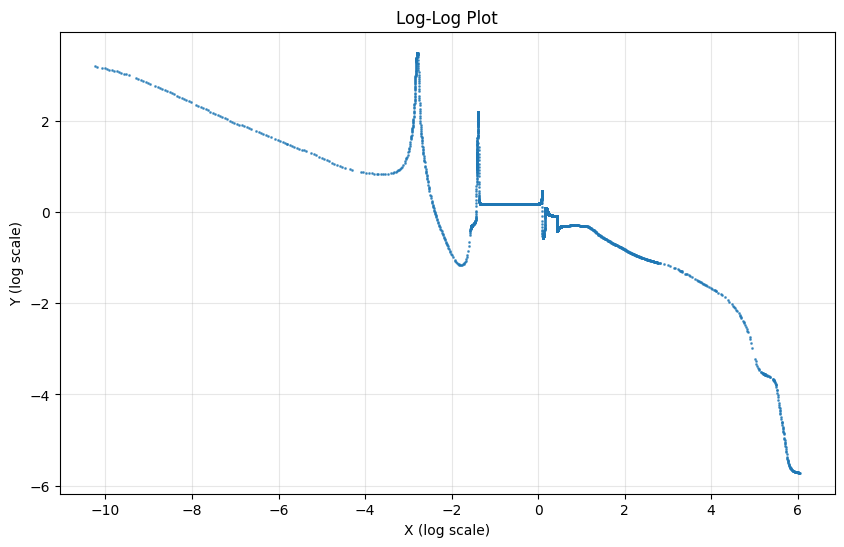

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuminx
x=np.array(train_ds["input"])
y = out_1# All rows, column 1

# Log-log plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', alpha=0.7, markersize=1)
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')
plt.title('Log-Log Plot')
plt.grid(True, alpha=0.3)
plt.show()